In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import warnings
import math

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor, XGBClassifier

from sklearn import set_config
set_config(display = 'diagram')
# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor,\
                            RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.cluster import KMeans

In [2]:
users_df = pd.read_csv('../raw_data/users.csv')
centers_df = pd.read_csv('../raw_data/distribution_centers.csv')
events_df = pd.read_csv('../raw_data/events.csv')
inventory_items_df = pd.read_csv('../raw_data/inventory_items.csv')
order_items_df = pd.read_csv('../raw_data/order_items.csv')
orders_df = pd.read_csv('../raw_data/orders.csv')
products_df = pd.read_csv('../raw_data/products.csv')

## basic join

In [11]:
def join_tables_item_level(order_items_df, products_df):
    '''
    Joins order-item & product
    '''
    order_items_df = order_items_df[['id', 
                                     'order_id', 
                                     'user_id', 
                                     'product_id', 
                                     'inventory_item_id',
                                     'status', 
                                     'created_at', 
                                     # 'shipped_at', 
                                     # 'delivered_at', 
                                     # 'returned_at',
                                     'sale_price']].rename(columns={'id':'order_item_id','status':'order_status'})    

    order_items_df['created_at'] = pd.to_datetime(order_items_df['created_at'],
                                                       format='mixed').dt.tz_localize(None)
    products_df = products_df[['id', 
                               'cost', 
                               'category', 
                               'name',
                               'brand',
                               'retail_price', 
                               'department',
                               # 'sku',
                               'distribution_center_id']]

    
    df_joined = order_items_df.merge(products_df, left_on='product_id', right_on='id', how='left')
    df_joined = df_joined.drop(columns=['id']) # duplicate product id    

    return df_joined

## Data Exploration

In [ ]:
# Check users
users_df_test = users_df.copy()
users_df_test['created_at'] = pd.to_datetime(users_df_test['created_at'],format='mixed').dt.tz_localize(None)
users_df_test.hist('created_at')

In [ ]:
# Check order trend
orders_test = orders_df.copy()
orders_test['created_at'] = pd.to_datetime(orders_test['created_at'],format='mixed').dt.tz_localize(None)
orders_test.hist('created_at')

In [ ]:
orders_cnt = orders_test.groupby(by='user_id')['order_id'].count().reset_index(name='orders')

orders_cnt['orders'].hist()

# Most of users only buy once

In [ ]:
users_test = orders_df.copy()
users_test['created_at'] = pd.to_datetime(users_test['created_at'],format='mixed').dt.tz_localize(None)

In [ ]:
users_test['year'] = users_test.created_at.dt.year

#### ? Users sign up early and buy later somehow

In [ ]:
orders_w_user = orders_test.merge(users_test[['user_id','created_at']].rename(columns={'created_at':'user_created_at'}), on='user_id')

In [ ]:
orders_w_user['months_from_signup'] = (orders_w_user.created_at-orders_w_user.user_created_at).dt.days/30

In [ ]:
orders_w_user.months_from_signup.hist()

# user_created_at is wrong

In [ ]:
orders_df.columns

#### ? Is there brands working bad in terms of return rate?

In [ ]:
item_product_df = join_tables_item_level(order_items_df, products_df)

In [ ]:
item_product_df['num_returns'] = item_product_df.

In [ ]:
item_product_df.groupby(by=['brand','order_status'])['order_id'].nunique().reset_index()

## Data Prep

In [4]:
def dtype_cast_datetime(orders_df):    
    # datetime format cast
    dt_columns = [ 'created_at', 'returned_at', 'shipped_at', 'delivered_at']

    for column in dt_columns:
        orders_df[column] = pd.to_datetime(orders_df[column],format='mixed').dt.tz_localize(None)

    return orders_df


In [5]:
def restructure_orders_prev_next(df):
    '''
    ---
    '''

    orders_df = dtype_cast_datetime(df).copy()
    # order ranks
    orders_df['order_rank'] = orders_df.groupby('user_id')['created_at'].rank(method='first').astype(int)
    orders_df = orders_df.sort_values(by=['user_id', 'order_rank'])

    # Calc delivery day
    orders_df['delivery_days'] = (orders_df['delivered_at'] - orders_df['created_at']).dt.days
    # Calc shipped day
    orders_df['delivery_days'] = (orders_df['shipped_at'] - orders_df['created_at']).dt.days

    # weekday
    orders_df['weekday_ordered'] = orders_df['created_at'].dt.dayofweek
    orders_df['weekday_delivered'] = orders_df['delivered_at'].dt.dayofweek

    # counts other status
    orders_df['returned?'] = orders_df['returned_at'].apply(lambda x : 1 if pd.notna(x) else 0)
    orders_df['shipped?'] = orders_df['shipped_at'].apply(lambda x : 1 if pd.notna(x) else 0)
    orders_df['delivered?'] = orders_df['delivered_at'].apply(lambda x : 1 if pd.notna(x) else 0)

    orders_df['return_cumsum'] = orders_df.groupby(by='user_id')['returned?'].cumsum()
    orders_df['ship_cumsum'] = orders_df.groupby(by='user_id')['shipped?'].cumsum()
    orders_df['deliver_cumsum'] = orders_df.groupby(by='user_id')['delivered?'].cumsum()
    
    # User-level T
    orders_df['min_order_created_at'] = orders_df.groupby(by='user_id')['created_at'].transform('min')
    orders_df['min_order_delivered_at'] = orders_df.groupby(by='user_id')['delivered_at'].transform('min')

    orders_df['customer_T'] = (orders_df['created_at']-orders_df['min_order_created_at']).dt.days
    orders_df['days_from_first_delivery'] = (orders_df['created_at']-orders_df['min_order_delivered_at']).dt.days
    
    # Total items
    orders_df['items_until_now'] = orders_df.groupby(by='user_id')['num_of_item'].cumsum()
    orders_df['num_items_delivered'] = orders_df.apply(lambda row: row['num_of_item'] if row['delivered?']==1 else 0, axis=1)
    orders_df['delivered_items_until_now'] = orders_df.groupby(by='user_id')['num_items_delivered'].cumsum()

    # avg days between orders

    # Next orders
    orders_next = orders_df.copy()
    orders_next['order_rank_prev'] = orders_next['order_rank']-1
    orders_next = orders_next[['user_id','order_id','order_rank_prev']].rename(columns={'order_id':'next_order_id'})
    
    orders_prev_next = orders_df.merge(orders_next, left_on=['user_id','order_rank'], right_on=['user_id','order_rank_prev'], how='left')

    orders_prev_next['next_order?'] = orders_prev_next['next_order_id'].notna()

    return orders_prev_next.drop(columns='order_rank_prev')

In [6]:
test = restructure_orders_prev_next(orders_df)

In [7]:
test[test['user_id'].isin([99983,44])][['order_id','user_id','created_at','order_rank','min_order_created_at','return_cumsum']]

,order_id,user_id,created_at,order_rank,min_order_created_at,return_cumsum
58,60,44,2023-01-20 02:12:00,1,2023-01-20 02:12:00,0
59,59,44,2023-09-11 02:12:00,2,2023-01-20 02:12:00,0
125207,125208,99983,2022-03-14 15:06:00,1,2022-03-14 15:06:00,0
125208,125209,99983,2022-09-07 15:06:00,2,2022-03-14 15:06:00,0
125209,125210,99983,2023-03-01 15:06:00,3,2022-03-14 15:06:00,0
125210,125211,99983,2023-08-25 15:06:00,4,2022-03-14 15:06:00,0


### distance to products

In [8]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the Earth's surface given their latitude and longitude
    in decimal degrees.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of Earth in kilometers. Use 3956 for miles
    return c * r

In [9]:
def calc_distance(products_df, centers_df, users_df, order_items_df):
    prod_center_df = products_df[['id','distribution_center_id']].merge(centers_df[['id','latitude','longitude']], 
                                                                        left_on='distribution_center_id', 
                                                                        right_on='id', how='left')\
                                                                .rename(
                                                                    columns={'id_x':'product_id',
                                                                             'latitude':'prod_lat',
                                                                             'longitude':'prod_lon'}).drop(columns='id_y')
    
    
    order_user_df = order_items_df[['order_id','user_id','product_id']].merge(users_df[['id','latitude','longitude']]
                                                                              , left_on= 'product_id', right_on = 'id', how='left')\
                                                                              .drop(columns='id') \
                                                                              .rename(columns={
                                                                                  'latitude':'user_lat',
                                                                                  'longitude':'user_lon'
                                                                              })
    
    distance_df = order_user_df.merge(prod_center_df, on='product_id', how='left')

    # Assuming df has columns 'lat1', 'lon1', 'lat2', 'lon2'
    distance_df['distance'] = distance_df.apply(lambda row: haversine(row['prod_lat'], row['prod_lon'], row['user_lat'], row['user_lon']), axis=1)

    result = distance_df.groupby(by='order_id')['distance'].mean().reset_index(name='avg_distance')

    return result



In [ ]:
calc_distance(products_df, centers_df, users_df, order_items_df)

## Joined Dataframe Aggregation
### -Calculates preffered brand and category

In [12]:
def product_info(item_level_df):
    '''
    takes item-level dataframe and calculate features to user level.
    '''

    base = item_level_df[['order_id','order_item_id']].groupby('order_id').count().fillna(0).rename(columns={'order_item_id':'num_order_item'}).reset_index()

    # order revenue
    revenue = item_level_df.groupby(by='order_id')['sale_price'].sum().reset_index(name='sale_price')
    base = base.merge(revenue, on='order_id', how='left') 
    
    # order retail_price
    revenue = item_level_df.groupby(by='order_id')['retail_price'].sum().reset_index(name='retail_price')
    base = base.merge(revenue, on='order_id', how='left') 
    
    
    # Most frequent category
    count_cat = item_level_df.groupby(['order_id', 'category']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index = count_cat.groupby('order_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_categories = count_cat.loc[max_count_index]
    # remove duplicates
    pref_cat_no_duplicates = preferred_categories.drop_duplicates(subset=['order_id']).rename(columns={'category':'category_preffered'})

    base = base.merge(pref_cat_no_duplicates[['order_id','category_preffered']],on='order_id',how='left')            


    # Department
    # Most frequent category
    count_dept = item_level_df.groupby(['order_id', 'department']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index_dept = count_dept.groupby('order_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_dept = count_dept.loc[max_count_index_dept]
    # remove duplicates
    pref_dept_no_duplicates = preferred_dept.drop_duplicates(subset=['order_id']).rename(columns={'department':'dept_pref'})

    base = base.merge(pref_dept_no_duplicates[['order_id','dept_pref']],on='order_id',how='left')    
    
    return base

## User dataset

In [13]:
def select_user_columns(users_df):

    df = users_df[['id','age','country','created_at','traffic_source']].rename(columns={'id':'user_id','created_at':'user_created_at'})
    # Filter users only for last 2 years from split date
    # min_date = split_date - pd.DateOffset(days=365*5)

    def assign_age_group(age):
        if age <= 15:
            return '00_15'
        elif age <= 25:
            return '16_25'
        elif age <= 35:
            return '26_35'
        elif age <= 45:
            return '36_45'
        elif age <= 55:
            return '46_55'
        else:
            return '56_99'

    df['age_group'] = df['age'].apply(assign_age_group)
    
    return df

## Event Dataset

In [14]:
def event_dataset(events_df):
    '''
    Returns most used browser per user_id
    '''
    
    events_df = events_df[events_df['user_id'].notna()].copy()
    events_df['created_at'] = pd.to_datetime(events_df['created_at'], format='mixed').dt.tz_localize(None)
    
    # Preffered browser
    count_browser = events_df.groupby(['user_id', 'browser']).size().reset_index(name='count')
    max_count_index = count_browser.groupby('user_id')['count'].idxmax()
    preferred_browser = count_browser.loc[max_count_index]
    pref_brsr_no_duplicates = preferred_browser.drop_duplicates(subset=['user_id']).rename(columns={'browser':'browser_pref'})
    base = pref_brsr_no_duplicates[['user_id','browser_pref']]

    return base

In [15]:
item_level_df = join_tables_item_level(order_items_df, products_df)

In [16]:
df_user = select_user_columns(users_df)
df_order = restructure_orders_prev_next(orders_df)
df_item = product_info(item_level_df)
df_event = event_dataset(events_df)
df_distance = calc_distance(products_df, centers_df, users_df, order_items_df)

## Testing to create user-event dataset

In [ ]:
order_event_jd = orders_df[['order_id', 'created_at']].merge(events_df[[]], on='user_id', how='left')

In [ ]:
order_event_jd.head(10)

## Checking if there are any duplicates

In [17]:
df_user.user_id.count(), df_user.user_id.nunique()

(100000, 100000)

In [20]:
df_order.order_id.count(), df_order.order_id.nunique()

(125226, 125226)

In [21]:
df_item.order_id.count(), df_item.order_id.nunique()

(125226, 125226)

In [22]:
df_event.user_id.count(), df_event.user_id.nunique()

(80044, 80044)

## Join all the prepped datasets

In [23]:
def prep_input_dataset(df_user, df_order, df_item, df_event, df_distance):
    '''
    joins all preprocessed user-level-df
    '''
    
    final_df = df_order.merge(df_user, on='user_id', how='left')
    final_df = final_df.merge(df_item, on='order_id', how='left')
    final_df = final_df.merge(df_event, on='user_id', how='left')
    final_df = final_df.merge(df_distance, on='order_id', how='left').reset_index()

    return final_df


In [24]:
input_dataset = prep_input_dataset(df_user, df_order, df_item, df_event, df_distance)

In [25]:
input_dataset.columns

Index(['index', 'order_id', 'user_id', 'status', 'gender', 'created_at',
       'returned_at', 'shipped_at', 'delivered_at', 'num_of_item',
       'order_rank', 'delivery_days', 'weekday_ordered', 'weekday_delivered',
       'returned?', 'shipped?', 'delivered?', 'return_cumsum', 'ship_cumsum',
       'deliver_cumsum', 'min_order_created_at', 'min_order_delivered_at',
       'customer_T', 'days_from_first_delivery', 'items_until_now',
       'num_items_delivered', 'delivered_items_until_now', 'next_order_id',
       'next_order?', 'age', 'country', 'user_created_at', 'traffic_source',
       'age_group', 'num_order_item', 'sale_price', 'retail_price',
       'category_preffered', 'dept_pref', 'browser_pref', 'avg_distance'],
      dtype='object')

In [26]:
input_dataset['next_order?'].value_counts()

next_order?
False    80044
True     45182
Name: count, dtype: int64

In [27]:
input_dataset['sale_ratio'] = input_dataset['sale_price']/input_dataset['retail_price']

In [28]:
input_dataset.columns

Index(['index', 'order_id', 'user_id', 'status', 'gender', 'created_at',
       'returned_at', 'shipped_at', 'delivered_at', 'num_of_item',
       'order_rank', 'delivery_days', 'weekday_ordered', 'weekday_delivered',
       'returned?', 'shipped?', 'delivered?', 'return_cumsum', 'ship_cumsum',
       'deliver_cumsum', 'min_order_created_at', 'min_order_delivered_at',
       'customer_T', 'days_from_first_delivery', 'items_until_now',
       'num_items_delivered', 'delivered_items_until_now', 'next_order_id',
       'next_order?', 'age', 'country', 'user_created_at', 'traffic_source',
       'age_group', 'num_order_item', 'sale_price', 'retail_price',
       'category_preffered', 'dept_pref', 'browser_pref', 'avg_distance',
       'sale_ratio'],
      dtype='object')

## Additional transformation

In [29]:
def month_sold(input_dataset):
    
    
    # Time that the order was placed

    ## Month
    months_in_a_year = 12

    input_dataset['MoSold'] = input_dataset['created_at'].dt.month
    input_dataset['sin_MoSold'] = np.sin(2 * np.pi * (input_dataset.MoSold - 1) / months_in_a_year)
    input_dataset['cos_MoSold'] = np.cos(2 * np.pi * (input_dataset.MoSold - 1) / months_in_a_year)    
    input_dataset.drop(columns=['MoSold'], inplace=True)


    ## Year
    input_dataset['year'] = input_dataset['created_at'].dt.year

    return input_dataset

In [30]:
input_dataset= month_sold(input_dataset)

## Define X, y

In [34]:
# List of columns to drop
columns_to_drop = ['index', 'order_id', 'user_id', 'created_at','returned_at', 'shipped_at', 'delivered_at', 
       'next_order_id', 'user_created_at','next_order?','min_order_created_at', 'min_order_delivered_at']

X = input_dataset.drop(columns=columns_to_drop).copy()
y = input_dataset['next_order?'].fillna(0).copy()

In [35]:
y_binary = y.apply(lambda x: 1 if x > 0 else 0)

In [36]:
X.columns

Index(['status', 'gender', 'num_of_item', 'order_rank', 'delivery_days',
       'weekday_ordered', 'weekday_delivered', 'returned?', 'shipped?',
       'delivered?', 'return_cumsum', 'ship_cumsum', 'deliver_cumsum',
       'customer_T', 'days_from_first_delivery', 'items_until_now',
       'num_items_delivered', 'delivered_items_until_now', 'age', 'country',
       'traffic_source', 'age_group', 'num_order_item', 'sale_price',
       'retail_price', 'category_preffered', 'dept_pref', 'browser_pref',
       'avg_distance', 'sale_ratio', 'sin_MoSold', 'cos_MoSold', 'year'],
      dtype='object')

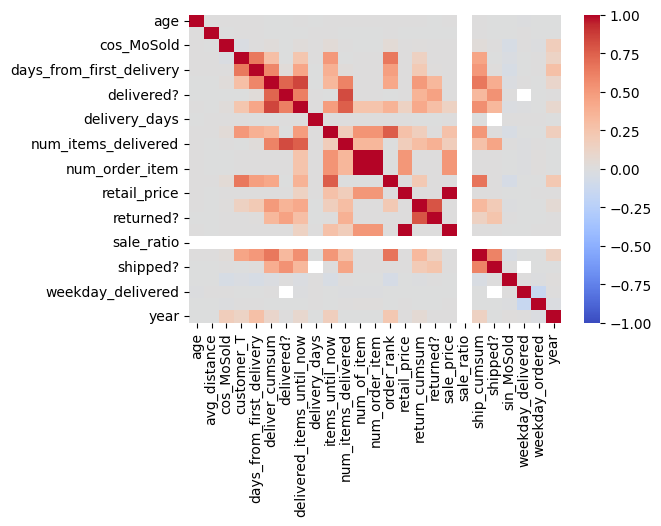

In [37]:
feat_numerical = sorted(X.select_dtypes(include=["int64", "int32","float64"]).columns)

corr_num = X[feat_numerical].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1);

In [38]:
X.shape, y.shape

((125226, 33), (125226,))

In [39]:
X.select_dtypes(include='object').nunique()

status                 5
gender                 2
country               16
traffic_source         5
age_group              6
category_preffered    26
dept_pref              2
browser_pref           5
dtype: int64

## Preprocessor Pipelines

In [40]:
preproc_numerical_baseline = make_pipeline(
    SimpleImputer(),
    MinMaxScaler()
)

preproc_categorical_baseline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)


preproc_baseline = make_column_transformer(
    (preproc_numerical_baseline, make_column_selector(dtype_include=["int64", "float64", "int32"])),
    (preproc_categorical_baseline, make_column_selector(dtype_include=["object"])),
    remainder="drop"
)

preproc_baseline

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f21b6672e90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f21b66738b0>)])

In [41]:
test = preproc_baseline.fit_transform(X)
test.shape

(125226, 92)

# Model Selection

## Trees

In [42]:
model = GradientBoostingClassifier(n_estimators=100, verbose=0)

pipe_gb = make_pipeline(preproc_baseline, model)
score = cross_val_score(pipe_gb, X, y_binary, cv=5, scoring='accuracy', n_jobs=-1).mean()

score

0.7448053734851172

In [43]:
pipe_randomforest = make_pipeline(preproc_baseline, RandomForestClassifier())
score_randomforest = cross_val_score(pipe_randomforest, X, y_binary, cv=5, scoring='accuracy', n_jobs=-1).mean()
score_randomforest

0.7360212503862129

In [44]:
model = AdaBoostClassifier(n_estimators=100, algorithm='SAMME')

pipe_ada = make_pipeline(preproc_baseline, model)
score = cross_val_score(pipe_ada, X, y_binary, cv=5, scoring='accuracy', n_jobs=-1).mean()

score

0.7326034512946568

In [46]:
estimators_ = [
    ('gbc', GradientBoostingClassifier()),
    ('rfc', RandomForestClassifier()),
    ('ada', AdaBoostClassifier())
]

model = VotingClassifier(estimators=estimators_)

pipe_vote = make_pipeline(preproc_baseline, model)
score = cross_val_score(pipe_vote, X, y_binary, cv=5, scoring='accuracy', n_jobs=-1).mean()

score

/home/jeongmin/.pyenv/versions/3.10.6/envs/clv-the-look/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/jeongmin/.pyenv/versions/3.10.6/envs/clv-the-look/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/jeongmin/.pyenv/versions/3.10.6/envs/clv-the-look/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/jeongmin/.pyenv/versions/3.10.6/envs/clv-the-look/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: Future

0.7436554561128784

In [ ]:
model = ExtraTreesClassifier()

pipe_ext = make_pipeline(preproc_baseline, model)
score = cross_val_score(pipe_ext, X, y_binary, cv=5, scoring='accuracy', n_jobs=-1).mean()

score

In [ ]:
model = BaggingClassifier()

pipe_bag = make_pipeline(preproc_baseline, model)
score = cross_val_score(pipe_bag, X, y_binary, cv=5, scoring='accuracy').mean()

score

In [ ]:
pipe_tree = make_pipeline(preproc_baseline, DecisionTreeClassifier())
score_tree = cross_val_score(pipe_tree, X, y_binary, cv=5, scoring='accuracy').mean()

score_tree

## KNN

In [45]:
pipe_knn = make_pipeline(preproc_baseline, KNeighborsClassifier())
score_knn = cross_val_score(pipe_knn, X, y_binary, cv=5, scoring='accuracy', n_jobs=-1).mean()
score_knn

## 0.587976953150862

0.5861801876481791

## SVM

In [ ]:
svm_classifier = SVC(kernal='poly', degree=3)

pipe_svc = make_pipeline(preproc_baseline, svm_classifier)

In [ ]:
score_svc = cross_val_score(pipe_svc, X, y_binary, cv=5, scoring='accuracy').mean()
score_svc

### Other models

## Fit, Predict, Evaluate

In [47]:
# Split train, test
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2)

In [48]:
pipe_selected = pipe_gb

In [49]:
pipe_selected.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f21b6672e90>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f21b66738b0>)])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [50]:
y_pred = pipe_selected.predict(X_test)

In [51]:
(y_pred.sum(), y_test.sum())

(4630, 8989)

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Assuming y_test contains the actual labels
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7453086321169049
Precision: 0.7818574514038877
Recall: 0.4027144287462454
F1-score: 0.5316102503854908
Confusion Matrix:
 [[15047  1010]
 [ 5369  3620]]


In [ ]:
# # Get the Random Forest model from the pipeline
# rf_model = pipe_selected.named_steps['randomforestclassifier']

# # Access feature importance from the Random Forest model
# feature_importance = rf_model.feature_importances_

# # Get the transformed feature names from OneHotEncoder
# one_hot_encoder = preproc_baseline.named_transformers_['pipeline-2']['onehotencoder']

# # Get the feature names after one-hot encoding
# encoded_columns = one_hot_encoder.get_feature_names_out()

## Explanation of the model

In [53]:
# Get the original numerical column names
numerical_columns = preproc_baseline.named_transformers_['pipeline-1']['simpleimputer'].get_feature_names_out()

# Concatenate the numerical column names with the one-hot encoded column names
all_column_names = list(numerical_columns) + list(encoded_columns)

# Ensure that the length of the concatenated list matches the length of the feature_importance array
assert len(all_column_names) == len(feature_importance), "Lengths of column names and feature importance values do not match"

NameError: name 'encoded_columns' is not defined

In [ ]:
# Get Feature importance
model = pipe_selected.named_steps['gradientboostingclassifier']

feature_importance = model.feature_importances_
one_hot_encoder = preproc_baseline.named_transformers_['pipeline-2']['onehotencoder']
encoded_columns = one_hot_encoder.get_feature_names_out()


numerical_columns = preproc_baseline.named_transformers_['pipeline-1']['simpleimputer'].get_feature_names_out()
all_column_names = list(numerical_columns) + list(encoded_columns)

# Ensure that the length of the concatenated list matches the length of the feature_importance array
assert len(all_column_names) == len(feature_importance), "Lengths of column names and feature importance values do not match"

In [ ]:
# Pair feature importance scores with corresponding column names
feature_importance_df = pd.DataFrame({'Feature': all_column_names, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:30], feature_importance_df['Importance'][:30])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')
plt.show()

## Save model

In [ ]:
import pickle
import joblib

In [ ]:
# # Define the filename for your .pkl file
# filename = '../clv_the_look/training/rf_model_v1.pkl'

# # Save the trained model to a .pkl file
# with open(filename, 'wb') as file:
#     pickle.dump(pipe_randomforest, file)

In [ ]:
filename = '../clv_the_look/training/gb_model_v1.pkl'

# Save the trained model to a .pkl file
with open(filename, 'wb') as file:
    joblib.dump(pipe_selected, filename)

In [ ]:
## input csv

X_test.to_csv('../clv_the_look/training/input_X_test.csv', index=False, encoding='utf-8')

X_test

## Try KNN

In [ ]:
test_country_event = events_df.groupby(by='user_id')['traffic_source'].nunique().reset_index()

In [ ]:
event_types_list = ['product','cart','department','purchase','cancel','home']

for idx, type in enumerate(event_types_list):
    print(idx, type)

In [ ]:
def cluster_event_df(events_df):
    '''
    Returns most used browser per user_id
    '''
    
    events_df = events_df[events_df['user_id'].notna()].copy()
    events_df['created_at'] = pd.to_datetime(events_df['created_at'], format='mixed').dt.tz_localize(None)

    # base
    base = events_df.groupby('user_id')['session_id'].nunique().reset_index(name='sessions')
    
    # Preffered browser
    count_browser = events_df.groupby(['user_id', 'browser']).size().reset_index(name='count')
    max_count_index = count_browser.groupby('user_id')['count'].idxmax()
    preferred_browser = count_browser.loc[max_count_index]
    pref_brsr_no_duplicates = preferred_browser.drop_duplicates(subset=['user_id']).rename(columns={'browser':'browser_pref'})
    base = base.merge(pref_brsr_no_duplicates[['user_id','browser_pref']],on='user_id',how='left')

    # types of events
    event_types_list = ['product','cart','department','purchase','cancel','home']
    
    for type in event_types_list:
        column_ = type + '_counts'
        user_behaviour = events_df[events_df['event_type']==type].groupby(by='user_id')['session_id'].nunique().reset_index(name=column_)
        base = base.merge(user_behaviour, on='user_id', how='left')
    
    
    return base

In [ ]:
select_user_columns(users_df)

In [ ]:
item_product_df.created_at.dt.year

In [ ]:
def cluser_item_product_agg(item_product_df):
    '''
    to user level
    '''

    base = item_level_df[['user_id','order_item_id']].groupby('user_id').count().fillna(0).rename(columns={'order_item_id':'num_order_items'}).reset_index()
    
    # order revenue
    revenue = item_level_df.groupby(by='user_id')['sale_price'].sum().reset_index(name='total_sales')
    base = base.merge(revenue, on='user_id', how='left') 
    
    # order retail_price
    retail_price = item_level_df.groupby(by='user_id')['retail_price'].sum().reset_index(name='total_retail_price')
    base = base.merge(retail_price, on='user_id', how='left') 

    # total_orders
    total_orders = item_level_df.groupby(by='user_id')['order_id'].nunique().reset_index(name='total_orders')
    base = base.merge(total_orders, on='user_id', how='left')

    # total_brands
    total_brands = item_level_df.groupby(by='user_id')['brand'].nunique().reset_index(name='total_num_brands')
    base = base.merge(total_brands, on='user_id', how='left')

    # firt order created at year, month
    year = item_level_df.groupby(by='user_id')['created_at'].min().reset_index(name='min_order_created_at')
    year['min_order_created_year'] = year.min_order_created_at.dt.year
    year['min_order_created_month'] = year.min_order_created_at.dt.month
    base = base.merge(year, on='user_id', how='left')

    base['abv'] = base.total_sales / base.total_orders

    # total_period
    max_date = item_level_df['created_at'].max()
    base['customer_T'] = (max_date - base['min_order_created_at']).dt.days
    
    
    
    # Most frequent category
    count_cat = item_level_df.groupby(['user_id', 'category']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index = count_cat.groupby('user_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_categories = count_cat.loc[max_count_index]
    # remove duplicates
    pref_cat_no_duplicates = preferred_categories.drop_duplicates(subset=['user_id']).rename(columns={'category':'category_preffered'})

    base = base.merge(pref_cat_no_duplicates[['user_id','category_preffered']],on='user_id',how='left')            


    # Department
    # Most frequent category
    count_dept = item_level_df.groupby(['user_id', 'department']).size().reset_index(name='count')
    # Find the index of the row with the maximum count for each user
    max_count_index_dept = count_dept.groupby('user_id')['count'].idxmax()
    # Extract the rows corresponding to the maximum counts
    preferred_dept = count_dept.loc[max_count_index_dept]
    # remove duplicates
    pref_dept_no_duplicates = preferred_dept.drop_duplicates(subset=['user_id']).rename(columns={'department':'dept_pref'})

    base = base.merge(pref_dept_no_duplicates[['user_id','dept_pref']],on='user_id',how='left')    
    
    return base

In [ ]:
item_product_df = join_tables_item_level(order_items_df, products_df)

In [ ]:
test = cluser_item_product_agg(item_product_df)

## Data Prep for Clustering

In [ ]:
user_prep = select_user_columns(users_df)
event_prep = cluster_event_df(events_df)
item_product_df = join_tables_item_level(order_items_df, products_df)
order_prep = cluser_item_product_agg(item_product_df)

In [ ]:
## Join all of them

input_prep = user_prep.copy()
input_prep = input_prep.merge(event_prep, on='user_id', how='left')
input_prep = input_prep.merge(order_prep, on='user_id', how='left')

columns_excl = ['user_id','user_created_at','min_order_created_at','min_order_created_at']

input_prep = input_prep.drop(columns=columns_excl)
input_prep.info()

In [ ]:
input_prep.isna().sum()

In [ ]:
input_prep['total_orders'].value_counts()

## preprocessing, fit, predict

In [ ]:
km_input = preproc_baseline.fit_transform(input_prep)

In [ ]:
prepped_values = pd.DataFrame(km_input.toarray())

In [ ]:
sns.heatmap(prepped_values.corr(), cmap='coolwarm')

In [ ]:
km_input.shape

In [ ]:
km = KMeans(n_clusters=4)
km.fit(km_input)

In [ ]:
cluster_labels= km.predict(km_input)
cluster_labels

In [ ]:
centroids = km.cluster_centers_
centroids.shape

In [ ]:
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))
print(cluster_counts)

## Trying DeepLearning

In [ ]:
''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Normalization
from tensorflow.keras.metrics import Recall, Precision


In [ ]:
X.head()

In [ ]:
# Preprocess
X_t = preproc_baseline.fit_transform(X)

In [ ]:
X_t.toarray()

In [ ]:
# Train test split before any resampling to keep real test set
X_train, X_test, y_train, y_test = train_test_split(X_t, y_binary, test_size = 0.3)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3)

In [ ]:
X_train = X_train.toarray()
X_val = X_val.toarray()

In [ ]:
# How many "fraud" samples do I have in each split?
print(np.sum(y_train[y_train == 1]))
print(np.sum(y_val[y_val == 1]))
print(np.sum(y_test[y_test == 1]))

print("-"*100)

print(f"There are {pd.Series(y_train).value_counts()[1]} purchased users in the train set")
print(f"There are {pd.Series(y_val).value_counts()[1]} purchased users in the val set")
print(f"There are {pd.Series(y_test).value_counts()[1]} purchased users in the test set")

In [ ]:
print(X_train.shape)
print(X_val.shape)

## Neural Network Iteration

In [ ]:
metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

In [ ]:
X_train.shape

In [ ]:
def init_model():
    input_shape = X_train.shape[1:]
    # normalizer = Normalization()
    # normalizer.adapt(X_train)
    
    model = models.Sequential()
    # model.add()
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Model compilation
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

## Regularized model

In [ ]:
[X_train.shape, y_train.shape]

In [ ]:
[X_val.shape, y_val.shape]

In [ ]:
model = init_model()

es = EarlyStopping(
    patience=10,
    monitor='val_recall', 
    restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=4,
                    callbacks=[es], shuffle=True)

In [ ]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()

In [ ]:
plot_loss_precision_recall_curve(history)

## Score it

In [ ]:
model.evaluate(X_test, y_test, verbose=0, return_dict=True)

In [ ]:
y_pred_proba = model.predict(X_test)

In [ ]:
threshold = 0.50 # 50% 

y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )

## Confusion Matrix

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_binary)
cm

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_binary))

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
plot_prc("Test", y_test, y_pred_proba, linestyle='--')
plt.legend(loc='lower right')